# Goals of this notebook
- Build flax.linen or flax.nnx modules for the EPIC-EIC architecture.
- This involves making modules for the core with trainable weights, slots with inputs, and lookup tables (LUTs) with non-trainable inter-core connectivity $\{-1, 0, 1\}$


## Summarizing the Connectivity patterns

We have the following:
1. rows and columns
2. cores
3. i/o slots
4. neighbors to all the cores
5. per slot there are neurons. Does that mean that the neurons only exist at the slots?

## Connectivity pattern
1. Cores that share a row and/or a column are connected. Tensor $C$ specifies these cores.
   1. e.g. $C[1, 1, 1, 2]$ represents if the cores present on row 1, col 1 and row 1, col 2 are connected. They are!
2. Each core has some number of neighbors. This number depends on perhaps where the core is located -- centrally located cored will have more neighbors.
   1. The tensor $N$ contains this info. It contains a linearly intexed list (0 to num_cores-1) and number of neighbors it has.
   2. e.g. $N[3, 2] = 2$ represents that there are $3$ cores with exactly $2$ neighbors.
3. The tensor $S$ determines how the cores can talk to each other. It describes how the slots are connected
   1. $S$ specifices how a core at a given row and column is connected to one of its neighbors through which i/o slots
   2. e.g. $S[1, 2, 3, 4, 1] = 1$ would imply that the core sitting at row 1, column 2, is connected to its neighbor #4, at the input slot #3 via its output slot #1 (verify this with Johannes). The 1 represents that such a connection exists.
4. Finally $W$ is the tensor containing all the weights. To find a weight between two neuron.

## Modules needed
1. Core module: with $256 \times 256$ weights.
2. Input Slot module: can accept a signed input vector. Each core should have 4 of these
3. Output slot module: vector - matrix multiplication ($64 \times 64$ weight $64 \times 1$ input vector) -- Not sure if this needs to be imp,emented explicitly!
4. Slot LUT module: For each input module, determine which core can send inputs.
5. External input module: Module that can provide external inputs to the cores. -- Does this need to be included in the Input Slot module

## Design
1. Make a module for the core. For every core initialize $256 \times 256$ weights. Each core should receive an input vector that is $256$ elements wide. This vector is stitched together from inputs from previous layer or external inputs.
2. Make a module for slots... TBD

In [39]:
import os
import numpy as np
import jax
import jax.numpy as jnp
import flax
from flax import linen as nn
from flax import nnx
import optax
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from tqdm.notebook import tqdm
from collections import defaultdict

from epic_ai_architecture_v1 import *

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simplified white-matter connectivity matrix
Define $V \in \{0, 1\}^{i,j,p,q}$ matrix as the white matter mask. It indexes the following way
$V[i,j, p, q] = 1$ if there is a connection between core $C[i, j]$ and $C[p, q]$ and zero otherwise.

$$
V[i, j, p, q] = \begin{cases}
1, \quad \text{if } C[i, j] \to C[p, q] \\
0, \quad \text{otherwise}
\end{cases}
$$

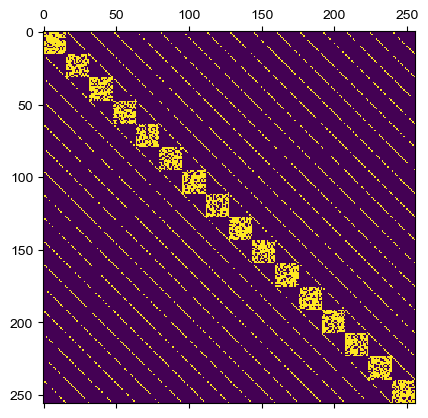

In [18]:
## simplified connectivity matrix
num_rows = 16
num_cols = 16
num_cores = num_rows * num_cols
alpha = 0.7

V = jnp.zeros((num_rows, num_cols, num_rows, num_cols))
key = jax.random.key(0)

## randomly connect all the cores on the same row, i.e. where i == p
for i in range(num_rows):
    key, split_key = jax.random.split(key)
    random_conn = jax.random.uniform(split_key, (num_cols, num_cols)) < alpha
    V = V.at[i, :, i, :].set(random_conn)

## randomly connect all the cores on the same column, i.e. where j == q
for i in range(num_cols):
    key, split_key = jax.random.split(key)
    random_conn = jax.random.uniform(split_key, (num_rows, num_rows)) < alpha
    V = V.at[:, i, :, i].set(random_conn)


# plot the matrix after reshaping
plt.matshow(V.reshape(num_cores, num_cores))


In [ ]:
# V = V.at[jnp.arange(num_rows), :, jnp.arange(num_rows), :].set(True)
# V = V.at[:, jnp.arange(num_cols), :, jnp.arange(num_cols)].set(True)

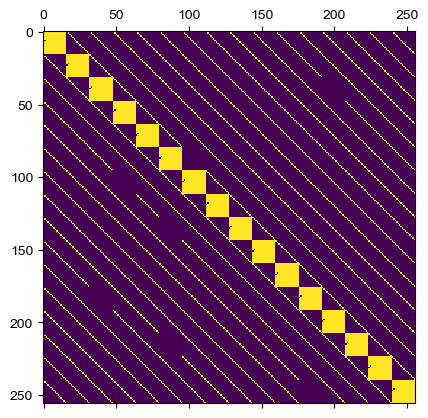

In [54]:
## is there another way to do this?
alpha = 0.99
V2 = jnp.zeros((num_rows, num_cols, num_rows, num_cols))
key, split_key = jax.random.split(key)

random_conn = jax.random.uniform(split_key, (num_cols, num_cols)) < alpha

V2 = V2.at[jnp.arange(num_rows), :, jnp.arange(num_rows), :].set(random_conn)

key, split_key = jax.random.split(key)
random_conn = jax.random.uniform(split_key, (num_rows, num_rows)) < alpha

V2 = V2.at[:, jnp.arange(num_cols), :, jnp.arange(num_cols)].set(random_conn)

plt.matshow(V2.reshape(num_cores, num_cores))

[0. 1. 0. 0. 0. 0. 0. 0. 1. 1.]


<Figure size 640x480 with 0 Axes>

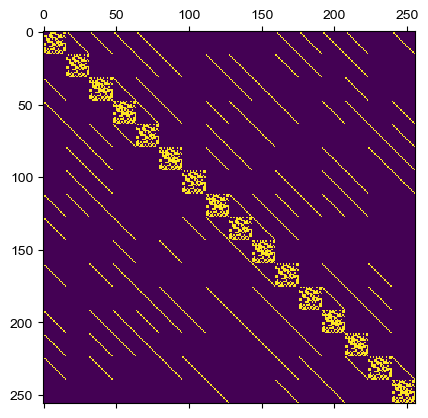

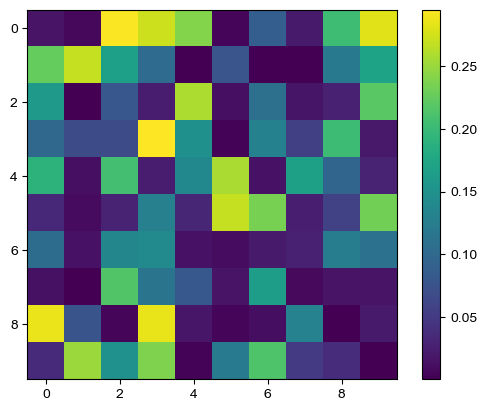

In [41]:
key = jax.random.key(0)
c1 = EICCore(num_inputs=10, num_outputs=10, key=key)
v_test = EICCore.intercore_connectivity(num_rows, num_cols, alpha, key)

x = jax.random.normal(key, (10,))*0.1
params = c1.init(key, x)
y, W = c1.apply(params, x)
print(y)

plt.figure()
plt.matshow(v_test.reshape(num_cores, num_cores))

plt.figure()
plt.imshow(W)
plt.colorbar()

In [53]:
xx = jnp.ones((5, 4))
yy = jnp.array([10, 20, 30, 40])[:, jnp.newaxis]
ww = xx @ yy
print(ww)

# x1 = x1.at[:5].set()
# x1 = x1.at[5:10] * 20
# x1 = x1.at[10:15] * 30
# x1 = x1.at[15:] * 40
# x1[:5] = x1[:5]*10
# x1[5:10] = x1[5:10]*20
# x1[10:15] = x1[10:15]*30
# x1[15:] = x1[15:]*40



[[100.]
 [100.]
 [100.]
 [100.]
 [100.]]


In [65]:
## splitting 2000 into chunks of 256
print(2000//256, 2000%256, 2000/256)

7 208 7.8125


In [68]:
1024*2/256

8.0

In [66]:
print(1000//256, 1000%256)
print(256*3 + 232)

3 232
1000


In [70]:
aa = jnp.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
print(aa)
print(jnp.sum(aa, axis = 0))
print(jnp.sum(aa, axis = 1))

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[12 15 18]
[ 6 15 24]


In [ ]:
def shuffle_input(x, block_size = 256, sub_block_size = 64, key = jax.random.key(0)):

    assert block_size % sub_block_size == 0, 'block_size must be a multiple of sub_block_size'

    num_sub_blocks = block_size//sub_block_size

    def shuffle_chunk(chunk, shuffle_key):
        indices = jax.random.permutation(shuffle_key, sub_block_size)
        return chunk[indices]
    
    keys = jax.random.split(key, num_sub_blocks)

    x_n = [
        shuffle_chunk(x[i * sub_block_size : (i + 1) * sub_block_size], k) 
        for i, k in zip(range(num_sub_blocks), keys)
    ]

    x_n = jnp.concatenate(x_n)

    return x, x_n

x = jnp.arange(64)
x, xn = shuffle_input(x, block_size = 16, sub_block_size = 4)

print(x[:8])
print(xn[:8])

## Correct this function!
    






[0 1 2 3 4 5 6 7]
[0 3 2 1 7 4 6 5]


In [ ]:
def shuffle_blocks(x, subvector_len, slot_len, key = jax.random.key(0)):
    """
    Shuffle the order of subblocks within each subvector.

    Args:
    x: jnp.ndarray, input vector of shape (input_len,)
    subvector_len: int, length of each subvector (typically 256 for EIC core)
    slot_len: int, length of each slot (typically 64 for EIC core)
    key: jax.random.PRNGKey, random key
    """

    assert subvector_len % slot_len == 0, "Slot length must be an integer multiple of input_len"

    ## for comments consider x = (1024,) vector

    # determine how many blocks are in the input vector
    num_subvectors = x.shape[0]//subvector_len # e.g. 1024//256 = 4 subvectors
    slots_per_input = subvector_len//slot_len # e.g. 256//64 = 4 slots per input

    # reshape x into a 3D tensor of shape (num_subvectors, slots_per_input, slot_len), e.g. (4, 4, 64)
    x = x.reshape(num_subvectors, slots_per_input, slot_len)

    assert x.shape == (num_subvectors, slots_per_input, slot_len), "Input shape is incorrect"

    

